# Var Implementation
This notebook walks through our Vector Auto Regression implementation as contained in the var_module.py module. 

In [1]:
import var_module as var
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns
from scipy.stats import norm
import copy

## Intialize our custom parameters
Predictors must match available columns exactly. City must match an available city exactly

In [2]:
filename = 'data_sw.csv'
df = pd.read_csv(filename)

In [3]:
city = "Tulsa"
order = 5
predictors = [
              'hourly_earnings',
              'unemployment_rate',
              'leisure',
              'housing_median_days_on_market',
              'housing_median_listing_price'
]
key_var = 'housing_median_listing_price'

seasonal_vars = [col for col in df.columns if '_s0' in col and col.split("_s0")[0] in predictors]
seasonal_vars

['housing_median_listing_price_s0', 'housing_median_days_on_market_s0']

## Initialize & Preprocess data
Ingest the raw data and generate the ouptut data frame with specified predictors

In [4]:
df = pd.read_csv(filename).query(f"city == '{city}'")
df = df.query("year < 2020")
df = df.dropna()
df.insert(3, 'year_month', df.year + df.month/100)
df = df.drop(columns = ['date','year','month','state']).reset_index(drop=True)
if city == 'Tulsa':
    df = df.loc[15:].reset_index(drop=True)

cols = ['year_month']
cols.extend([col for col in df.columns if 'hous' in col if 'price' in col])
df[cols]

,year_month,housing_median_listing_price,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0
0,2017.10,209950.0000,210000.0000,219200.0000,215000.0000,219250.0000,214500.0000,197900.0
1,2017.11,208750.0000,209950.0000,210000.0000,219200.0000,215000.0000,219250.0000,195000.0
2,2017.12,204557.0000,208750.0000,209950.0000,210000.0000,219200.0000,215000.0000,192000.0
3,2018.01,203750.0000,204557.0000,208750.0000,209950.0000,210000.0000,219200.0000,196500.0
4,2018.02,207450.0000,203750.0000,204557.0000,208750.0000,209950.0000,210000.0000,199949.5
5,2018.03,215000.0000,207450.0000,203750.0000,204557.0000,208750.0000,209950.0000,203768.5
6,2018.04,220499.5000,215000.0000,207450.0000,203750.0000,204557.0000,208750.0000,210000.0
7,2018.05,219900.0000,220499.5000,215000.0000,207450.0000,203750.0000,204557.0000,214500.0
8,2018.06,215000.0000,219900.0000,220499.5000,215000.0000,207450.0000,203750.0000,219250.0
9,2018.07,215000.0000,215000.0000,219900.0000,220499.5000,215000.0000,207450.0000,215000.0


In [5]:
base_cols = ['year_month','city']
drop_cols = []

for pred in predictors:
    for col in list(df.columns):
        if pred in col:
            base_cols.append(col)
df = df[base_cols].reset_index(drop=True)
df = df.rename({'city':'city_'}, axis=1)
input_df = df.reset_index(drop=True)
input_df.head(10)

,year_month,city_,hourly_earnings,hourly_earnings_4,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,unemployment_rate,unemployment_rate_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,leisure,leisure_4,leisure_3,leisure_2,leisure_1,leisure_0,housing_median_days_on_market,housing_median_days_on_market_4,housing_median_days_on_market_3,housing_median_days_on_market_2,housing_median_days_on_market_1,housing_median_days_on_market_0,housing_median_days_on_market_s0,housing_median_listing_price,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0
0,2017.10,Tulsa,25.181154,25.185989,25.181083,25.159706,25.012794,24.843794,4.1,4.1,4.2,4.2,4.2,4.3,36.304319,36.451190,36.478690,36.479736,36.712736,36.528509,62.5,61.0,58.0,54.0,52.5,51.0,60.0,209950.0,210000.0,219200.0,215000.0,219250.0,214500.0,197900.0
1,2017.11,Tulsa,25.280280,25.181154,25.185989,25.181083,25.159706,25.012794,4.0,4.1,4.1,4.2,4.2,4.2,36.255936,36.304319,36.451190,36.478690,36.479736,36.712736,63.0,62.5,61.0,58.0,54.0,52.5,62.5,208750.0,209950.0,210000.0,219200.0,215000.0,219250.0,195000.0
2,2017.12,Tulsa,25.288257,25.280280,25.181154,25.185989,25.181083,25.159706,3.9,4.0,4.1,4.1,4.2,4.2,36.359012,36.255936,36.304319,36.451190,36.478690,36.479736,65.0,63.0,62.5,61.0,58.0,54.0,68.0,204557.0,208750.0,209950.0,210000.0,219200.0,215000.0,192000.0
3,2018.01,Tulsa,25.049890,25.288257,25.280280,25.181154,25.185989,25.181083,3.8,3.9,4.0,4.1,4.1,4.2,36.575407,36.359012,36.255936,36.304319,36.451190,36.478690,68.0,65.0,63.0,62.5,61.0,58.0,69.0,203750.0,204557.0,208750.0,209950.0,210000.0,219200.0,196500.0
4,2018.02,Tulsa,25.503023,25.049890,25.288257,25.280280,25.181154,25.185989,3.7,3.8,3.9,4.0,4.1,4.1,36.452862,36.575407,36.359012,36.255936,36.304319,36.451190,64.5,68.0,65.0,63.0,62.5,61.0,63.5,207450.0,203750.0,204557.0,208750.0,209950.0,210000.0,199949.5
5,2018.03,Tulsa,25.330223,25.503023,25.049890,25.288257,25.280280,25.181154,3.6,3.7,3.8,3.9,4.0,4.1,36.787934,36.452862,36.575407,36.359012,36.255936,36.304319,52.0,64.5,68.0,65.0,63.0,62.5,52.5,215000.0,207450.0,203750.0,204557.0,208750.0,209950.0,203768.5
6,2018.04,Tulsa,25.496766,25.330223,25.503023,25.049890,25.288257,25.280280,3.5,3.6,3.7,3.8,3.9,4.0,36.706356,36.787934,36.452862,36.575407,36.359012,36.255936,50.0,52.0,64.5,68.0,65.0,63.0,51.0,220499.5,215000.0,207450.0,203750.0,204557.0,208750.0,210000.0
7,2018.05,Tulsa,25.493961,25.496766,25.330223,25.503023,25.049890,25.288257,3.4,3.5,3.6,3.7,3.8,3.9,36.647685,36.706356,36.787934,36.452862,36.575407,36.359012,47.0,50.0,52.0,64.5,68.0,65.0,51.0,219900.0,220499.5,215000.0,207450.0,203750.0,204557.0,214500.0
8,2018.06,Tulsa,25.790278,25.493961,25.496766,25.330223,25.503023,25.049890,3.3,3.4,3.5,3.6,3.7,3.8,36.634562,36.647685,36.706356,36.787934,36.452862,36.575407,50.0,47.0,50.0,52.0,64.5,68.0,52.5,215000.0,219900.0,220499.5,215000.0,207450.0,203750.0,219250.0
9,2018.07,Tulsa,25.992526,25.790278,25.493961,25.496766,25.330223,25.503023,3.2,3.3,3.4,3.5,3.6,3.7,36.844166,36.634562,36.647685,36.706356,36.787934,36.452862,57.5,50.0,47.0,50.0,52.0,64.5,54.0,215000.0,215000.0,219900.0,220499.5,215000.0,207450.0,215000.0


## Generate pymc3 Model
This will automatically write the code needed to generate a pymc3 model using our predictors that will be used for variational inference. See hidden cell for parameters in the model.

In [6]:
var.write_model_module(input_df=input_df, key_var=key_var, seasonal_vars=seasonal_vars)

import model_builder
model_comb = model_builder.build_model(input_df=input_df)

In [7]:
pm.model_to_graphviz(model_comb)

## Generate posterior predictions for our coefficients
This utilizes ADVI implementation of variational inference in pymc3 to generate our posterior predictions (this can take a few minutes)

In [8]:
parameters = var.generate_advi_posterior(model_comb)
parameters

Finished [100%]: Average Loss = 1,145.1


,variable,mean,std
0,sigma_hourly_earnings_log__,-1.409,0.15817
1,intercept_hourly_earnings,0.271,0.05379
2,hourly_earnings_4_hourly_earnings,0.231,0.00213
3,hourly_earnings_3_hourly_earnings,0.226,0.00205
4,hourly_earnings_2_hourly_earnings,0.198,0.00209
...,...,...,...
58,sigma_hourly_earnings,0.247,0.03936
59,sigma_unemployment_rate,0.080,0.01264
60,sigma_leisure,0.275,0.04500
61,sigma_housing_median_days_on_market,3.023,0.48381


# Run the forward model 
input the starting time period (formatted yyyy.mm) and the number of steps that you want to advance in your predictions. This will deliver a dataframe with your posterior predictions for however many steps you want to project to. The standard deviation dataframe gives you the spread of each of the predictions.

In [9]:
df_preds = var.get_initial_prediction(input=input_df, year_month=2018.12, order=order, seasonal_vars=seasonal_vars)
df_preds

,city_,year_month,hourly_earnings_4,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,unemployment_rate_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,leisure_4,leisure_3,leisure_2,leisure_1,leisure_0,housing_median_days_on_market_4,housing_median_days_on_market_3,housing_median_days_on_market_2,housing_median_days_on_market_1,housing_median_days_on_market_0,housing_median_listing_price_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0,housing_median_days_on_market_s0
0,Tulsa,2018.12,26.039823,25.881842,26.249768,25.976188,26.004278,3.2,3.2,3.1,3.1,3.1,37.488839,37.306179,37.112769,36.802144,37.003726,67.0,65.0,64.5,60.0,58.0,215000.0,219150.0,214649.5,214900.0,214900.0,204557.0,65.0


In [10]:
df_mean, df_std = var.get_new_prediction(df_preds, input_df, parameters, samples=10000, order=order, df_stdev=pd.DataFrame(), first=True)
df_mean

,city_,year_month,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,hourly_earnings_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,unemployment_rate_4,leisure_3,leisure_2,leisure_1,leisure_0,leisure_4,housing_median_days_on_market_3,housing_median_days_on_market_2,housing_median_days_on_market_1,housing_median_days_on_market_0,housing_median_days_on_market_s0,housing_median_days_on_market_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0,housing_median_listing_price_4
0,Tulsa,2019.01,26.039823,25.881842,26.249768,25.976188,26.01,3.2,3.2,3.1,3.1,3.17,37.488839,37.306179,37.112769,36.802144,37.21,67.0,65.0,64.5,60.0,68.0,65.93,215000.0,219150.0,214649.5,214900.0,203750.0,217482.05


In [11]:
steps = 12
df_preds = var.get_initial_prediction(input=input_df, year_month=2018.12, order=order, seasonal_vars=seasonal_vars)

df_mean, df_std = var.get_new_prediction(df_preds=df_preds, input_df=input_df, parameters=parameters, samples=1000000, order=order, first=True)

df_new = df_mean
df_nstd = df_std

for i in range(12):
    df_mean, df_std = var.get_new_prediction(df_preds=df_mean, input_df=input_df, parameters=parameters, samples=1000000, order=order, first=True, df_stdev=df_std)
    df_new = pd.concat([df_new, df_mean]).reset_index(drop=True)
    df_nstd = pd.concat([df_nstd, df_std]).reset_index(drop=True)

df_new

,city_,year_month,hourly_earnings_3,hourly_earnings_2,hourly_earnings_1,hourly_earnings_0,hourly_earnings_4,unemployment_rate_3,unemployment_rate_2,unemployment_rate_1,unemployment_rate_0,unemployment_rate_4,leisure_3,leisure_2,leisure_1,leisure_0,leisure_4,housing_median_days_on_market_3,housing_median_days_on_market_2,housing_median_days_on_market_1,housing_median_days_on_market_0,housing_median_days_on_market_s0,housing_median_days_on_market_4,housing_median_listing_price_3,housing_median_listing_price_2,housing_median_listing_price_1,housing_median_listing_price_0,housing_median_listing_price_s0,housing_median_listing_price_4
0,Tulsa,2019.01,26.039823,25.881842,26.249768,25.976188,26.01,3.20,3.20,3.10,3.10,3.17,37.488839,37.306179,37.112769,36.802144,37.20,67.00,65.00,64.50,60.00,68.0,65.91,215000.00,219150.00,214649.50,214900.00,203750.0,217441.54
1,Tulsa,2019.02,26.010000,26.039823,25.881842,26.249768,26.01,3.17,3.20,3.20,3.10,3.16,37.200000,37.488839,37.306179,37.112769,37.24,65.91,67.00,65.00,64.50,64.5,67.28,217441.54,215000.00,219150.00,214649.50,207450.0,217984.30
2,Tulsa,2019.03,26.010000,26.010000,26.039823,25.881842,26.01,3.16,3.17,3.20,3.20,3.14,37.240000,37.200000,37.488839,37.306179,37.31,67.28,65.91,67.00,65.00,52.0,65.90,217984.30,217441.54,215000.00,219150.00,215000.0,219099.02
3,Tulsa,2019.04,26.010000,26.010000,26.010000,26.039823,25.98,3.14,3.16,3.17,3.20,3.13,37.310000,37.240000,37.200000,37.488839,37.34,65.90,67.28,65.91,67.00,50.0,56.38,219099.02,217984.30,217441.54,215000.00,220499.5,221174.85
4,Tulsa,2019.05,25.980000,26.010000,26.010000,26.010000,25.99,3.13,3.14,3.16,3.17,3.11,37.340000,37.310000,37.240000,37.200000,37.35,56.38,65.90,67.28,65.91,47.0,52.30,221174.85,219099.02,217984.30,217441.54,219900.0,223427.09
5,Tulsa,2019.06,25.990000,25.980000,26.010000,26.010000,25.98,3.11,3.13,3.14,3.16,3.10,37.350000,37.340000,37.310000,37.240000,37.33,52.30,56.38,65.90,67.28,50.0,48.50,223427.09,221174.85,219099.02,217984.30,215000.0,225169.58
6,Tulsa,2019.07,25.980000,25.990000,25.980000,26.010000,25.98,3.10,3.11,3.13,3.14,3.09,37.330000,37.350000,37.340000,37.310000,37.35,48.50,52.30,56.38,65.90,57.5,50.43,225169.58,223427.09,221174.85,219099.02,215000.0,226112.28
7,Tulsa,2019.08,25.980000,25.980000,25.990000,25.980000,25.97,3.09,3.10,3.11,3.13,3.08,37.350000,37.330000,37.350000,37.340000,37.37,50.43,48.50,52.30,56.38,58.0,57.94,226112.28,225169.58,223427.09,221174.85,214900.0,227195.02
8,Tulsa,2019.09,25.970000,25.980000,25.980000,25.990000,25.96,3.08,3.09,3.10,3.11,3.07,37.370000,37.350000,37.330000,37.350000,37.39,57.94,50.43,48.50,52.30,60.0,59.87,227195.02,226112.28,225169.58,223427.09,214900.0,228111.98
9,Tulsa,2019.10,25.960000,25.970000,25.980000,25.980000,25.96,3.07,3.08,3.09,3.10,3.06,37.390000,37.370000,37.350000,37.330000,37.40,59.87,57.94,50.43,48.50,64.5,61.65,228111.98,227195.02,226112.28,225169.58,214649.5,228944.05


In [12]:
df_nstd

,city_,year_month,hourly_earnings_4,unemployment_rate_4,leisure_4,housing_median_days_on_market_4,housing_median_listing_price_4,hourly_earnings_3,unemployment_rate_3,leisure_3,housing_median_days_on_market_3,housing_median_listing_price_3,hourly_earnings_2,unemployment_rate_2,leisure_2,housing_median_days_on_market_2,housing_median_listing_price_2,hourly_earnings_1,unemployment_rate_1,leisure_1,housing_median_days_on_market_1,housing_median_listing_price_1,hourly_earnings_0,unemployment_rate_0,leisure_0,housing_median_days_on_market_0,housing_median_listing_price_0
0,Tulsa,2019.01,0.13,0.04,0.15,1.81,3569.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tulsa,2019.02,0.13,0.04,0.15,1.86,3598.19,0.13,0.04,0.15,1.81,3569.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tulsa,2019.03,0.13,0.04,0.15,1.87,3617.96,0.13,0.04,0.15,1.86,3598.19,0.13,0.04,0.15,1.81,3569.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tulsa,2019.04,0.13,0.04,0.15,1.83,3621.14,0.13,0.04,0.15,1.87,3617.96,0.13,0.04,0.15,1.86,3598.19,0.13,0.04,0.15,1.81,3569.10,NaN,NaN,NaN,NaN,NaN
4,Tulsa,2019.05,0.13,0.04,0.15,1.79,3616.12,0.13,0.04,0.15,1.83,3621.14,0.13,0.04,0.15,1.87,3617.96,0.13,0.04,0.15,1.86,3598.19,0.13,0.04,0.15,1.81,3569.10
5,Tulsa,2019.06,0.13,0.04,0.15,1.72,3590.29,0.13,0.04,0.15,1.79,3616.12,0.13,0.04,0.15,1.83,3621.14,0.13,0.04,0.15,1.87,3617.96,0.13,0.04,0.15,1.86,3598.19
6,Tulsa,2019.07,0.13,0.04,0.15,1.66,3564.11,0.13,0.04,0.15,1.72,3590.29,0.13,0.04,0.15,1.79,3616.12,0.13,0.04,0.15,1.83,3621.14,0.13,0.04,0.15,1.87,3617.96
7,Tulsa,2019.08,0.13,0.04,0.15,1.62,3555.75,0.13,0.04,0.15,1.66,3564.11,0.13,0.04,0.15,1.72,3590.29,0.13,0.04,0.15,1.79,3616.12,0.13,0.04,0.15,1.83,3621.14
8,Tulsa,2019.09,0.13,0.04,0.15,1.59,3560.74,0.13,0.04,0.15,1.62,3555.75,0.13,0.04,0.15,1.66,3564.11,0.13,0.04,0.15,1.72,3590.29,0.13,0.04,0.15,1.79,3616.12
9,Tulsa,2019.10,0.13,0.04,0.15,1.60,3581.63,0.13,0.04,0.15,1.59,3560.74,0.13,0.04,0.15,1.62,3555.75,0.13,0.04,0.15,1.66,3564.11,0.13,0.04,0.15,1.72,3590.29


In [13]:
def run_projections(order, input, start_year_month, steps, parameters,seasonal_vars,key_var, samples=1000000, log_transform=False):

    df_pred = var.get_initial_prediction(input=input, year_month=start_year_month, order=order, seasonal_vars=seasonal_vars)
    max_num = order - 1

    mean_df = pd.DataFrame()
    std_df = pd.DataFrame()

    means, stds = var.get_new_prediction(
        df_preds=df_pred,
        input_df=input,
        parameters=parameters,
        samples=samples,
        first=True,
        order=order,
    )
    # print(means)
    mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
    std_df = pd.concat([std_df, stds]).reset_index(drop=True)

    for i in range(steps - 1):
        means, stds = var.get_new_prediction(
            df_preds=means,
            input_df=input,
            parameters=parameters,
            samples=samples,
            first=False,
            df_stdev=stds,
            order=order,
        )
        mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
        std_df = pd.concat([std_df, stds]).reset_index(drop=True)
    mean_df = mean_df[["city_", "year_month", f"{key_var}_{max_num}"]]
    mean_df.insert(
        1, "year", (round(mean_df.year_month - (mean_df.year_month % 1), 0)).astype(int)
    )
    mean_df.insert(2, "month", round(mean_df.year_month % 1 * 100, 0).astype(int))
    mean_df.insert(3, "day", 1)
    mean_df.insert(4, "date", pd.to_datetime(mean_df[["year", "month", "day"]]))

    std_df = std_df[["city_", "year_month", f"{key_var}_{max_num}"]]
    std_df.insert(
        1, "year", (round(std_df.year_month - (std_df.year_month % 1), 0)).astype(int)
    )
    std_df.insert(2, "month", round(std_df.year_month % 1 * 100, 0).astype(int))
    std_df.insert(3, "day", 1)
    std_df.insert(4, "date", pd.to_datetime(std_df[["year", "month", "day"]]))

    if log_transform:
        mean_df[f"{key_var}_{max_num}"] = np.exp(mean_df[f"{key_var}_{max_num}"])
        std_df[f"{key_var}_{max_num}"] = np.exp(std_df[f"{key_var}_{max_num}"])

    return mean_df, std_df

In [14]:
print(order)
mean_df, std_df = run_projections(order=order, input=input_df, start_year_month=2018.12, samples=1000000, steps=12, parameters=parameters, key_var=key_var, seasonal_vars=seasonal_vars)
mean_df

5


,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Tulsa,2019,1,1,2019-01-01,2019.01,217447.21
1,Tulsa,2019,2,1,2019-02-01,2019.02,217989.31
2,Tulsa,2019,3,1,2019-03-01,2019.03,219101.68
3,Tulsa,2019,4,1,2019-04-01,2019.04,221170.98
4,Tulsa,2019,5,1,2019-05-01,2019.05,223426.90
5,Tulsa,2019,6,1,2019-06-01,2019.06,225169.25
6,Tulsa,2019,7,1,2019-07-01,2019.07,226109.55
7,Tulsa,2019,8,1,2019-08-01,2019.08,227199.31
8,Tulsa,2019,9,1,2019-09-01,2019.09,228115.20
9,Tulsa,2019,10,1,2019-10-01,2019.10,228948.54


In [15]:
std_df

,city_,year,month,day,date,year_month,housing_median_listing_price_4
0,Tulsa,2019,1,1,2019-01-01,2019.01,3571.39
1,Tulsa,2019,2,1,2019-02-01,2019.02,4096.04
2,Tulsa,2019,3,1,2019-03-01,2019.03,4333.98
3,Tulsa,2019,4,1,2019-04-01,2019.04,4447.07
4,Tulsa,2019,5,1,2019-05-01,2019.05,4489.71
5,Tulsa,2019,6,1,2019-06-01,2019.06,4493.09
6,Tulsa,2019,7,1,2019-07-01,2019.07,4483.90
7,Tulsa,2019,8,1,2019-08-01,2019.08,4474.44
8,Tulsa,2019,9,1,2019-09-01,2019.09,4476.44
9,Tulsa,2019,10,1,2019-10-01,2019.10,4486.45


# Visualize

In [39]:
temp = pd.merge(left=mean_df, right=std_df[['date','housing_median_listing_price_4']], on = 'date', how= 'left').rename({'housing_median_listing_price_4':'std'}, axis=1)

new_dates = []
new_prices = []
for i in range(len(temp)):
    mean = temp.housing_median_listing_price.loc[i]
    std = temp['std'].loc[i]
    for u in range(3):
        new_dates.append(temp.date.loc[i])

        if u == 0:
            new_prices.append(mean+(1.96*std))
        elif u == 1:
            new_prices.append(mean-(1.96*std))
        else:
            new_prices.append(mean)

intervals = pd.DataFrame({
    "date":new_dates,
    "housing_median_listing_price":new_prices,
    'actual_prediction':'prediction'
})
intervals

,date,housing_median_listing_price,actual_prediction
0,2019-01-01,224447.1344,prediction
1,2019-01-01,210447.2856,prediction
2,2019-01-01,217447.2100,prediction
3,2019-02-01,226017.5484,prediction
4,2019-02-01,209961.0716,prediction
5,2019-02-01,217989.3100,prediction
6,2019-03-01,227596.2808,prediction
7,2019-03-01,210607.0792,prediction
8,2019-03-01,219101.6800,prediction
9,2019-04-01,229887.2372,prediction


In [40]:
start_year = 2018

new_input = copy.deepcopy(input_df)

new_input.insert(
    1, "year", (round(new_input.year_month - (new_input.year_month % 1), 0)).astype(int)
)
new_input.insert(2, "month", round(new_input.year_month % 1 * 100, 0).astype(int))
new_input.insert(3, "day", 1)
new_input.insert(4, "date", pd.to_datetime(new_input[["year", "month", "day"]]))
new_input = new_input[['city_','year','month','date','year_month','housing_median_listing_price']]
new_input = new_input.query(f"year >= {start_year}")
new_input['actual_prediction'] = 'actual'

df_line = pd.concat([new_input, intervals]).reset_index(drop=True)
df_line

,city_,year,month,date,year_month,housing_median_listing_price,actual_prediction
0,Tulsa,2018.0,1.0,2018-01-01,2018.01,203750.0000,actual
1,Tulsa,2018.0,2.0,2018-02-01,2018.02,207450.0000,actual
2,Tulsa,2018.0,3.0,2018-03-01,2018.03,215000.0000,actual
3,Tulsa,2018.0,4.0,2018-04-01,2018.04,220499.5000,actual
4,Tulsa,2018.0,5.0,2018-05-01,2018.05,219900.0000,actual
5,Tulsa,2018.0,6.0,2018-06-01,2018.06,215000.0000,actual
6,Tulsa,2018.0,7.0,2018-07-01,2018.07,215000.0000,actual
7,Tulsa,2018.0,8.0,2018-08-01,2018.08,214900.0000,actual
8,Tulsa,2018.0,9.0,2018-09-01,2018.09,214900.0000,actual
9,Tulsa,2018.0,10.0,2018-10-01,2018.10,214649.5000,actual


Text(0.5, 1.0, 'Actual Housing Market v Model Prediction for Tulsa')

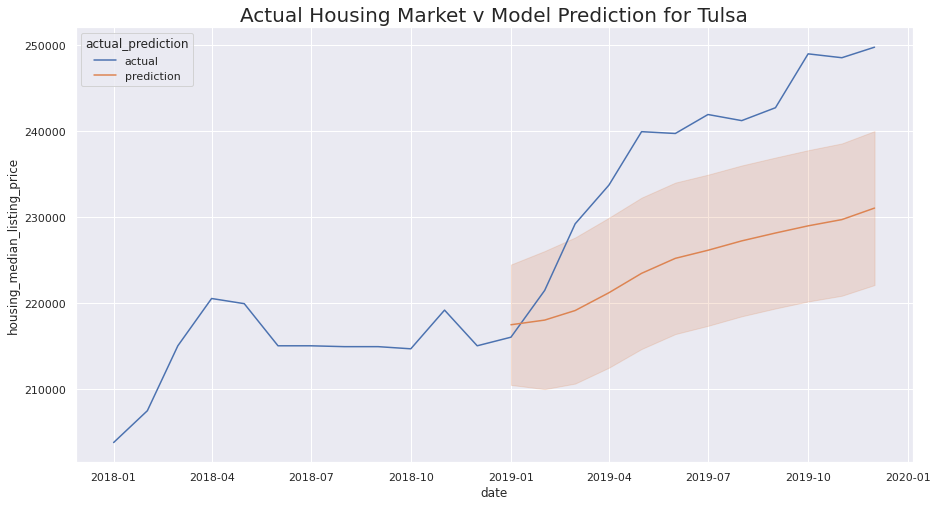

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.lineplot(data=df_line, x='date',y='housing_median_listing_price', hue='actual_prediction').set_title(f"Actual Housing Market v Model Prediction for {city}", fontsize = 20)

In [16]:
start_year = 2018

new_input = copy.deepcopy(input_df)

new_input.insert(
    1, "year", (round(new_input.year_month - (new_input.year_month % 1), 0)).astype(int)
)
new_input.insert(2, "month", round(new_input.year_month % 1 * 100, 0).astype(int))
new_input.insert(3, "day", 1)
new_input.insert(4, "date", pd.to_datetime(new_input[["year", "month", "day"]]))
new_input = new_input[['city_','year','month','date','year_month','housing_median_listing_price']]
new_input = new_input.query(f"year >= {start_year}")
new_input['actual_prediction'] = 'actual'

mean_df = mean_df.rename({'housing_median_listing_price_4':'housing_median_listing_price'}, axis=1)
mean_df['actual_prediction'] = 'prediction'
df_line = pd.concat([new_input, mean_df]).reset_index(drop=True)
df_line

,city_,year,month,date,year_month,housing_median_listing_price,actual_prediction,day
0,Tulsa,2018,1,2018-01-01,2018.01,203750.0000,actual,NaN
1,Tulsa,2018,2,2018-02-01,2018.02,207450.0000,actual,NaN
2,Tulsa,2018,3,2018-03-01,2018.03,215000.0000,actual,NaN
3,Tulsa,2018,4,2018-04-01,2018.04,220499.5000,actual,NaN
4,Tulsa,2018,5,2018-05-01,2018.05,219900.0000,actual,NaN
5,Tulsa,2018,6,2018-06-01,2018.06,215000.0000,actual,NaN
6,Tulsa,2018,7,2018-07-01,2018.07,215000.0000,actual,NaN
7,Tulsa,2018,8,2018-08-01,2018.08,214900.0000,actual,NaN
8,Tulsa,2018,9,2018-09-01,2018.09,214900.0000,actual,NaN
9,Tulsa,2018,10,2018-10-01,2018.10,214649.5000,actual,NaN


Text(0.5, 1.0, 'Actual Housing Market v Model Prediction for Tulsa')

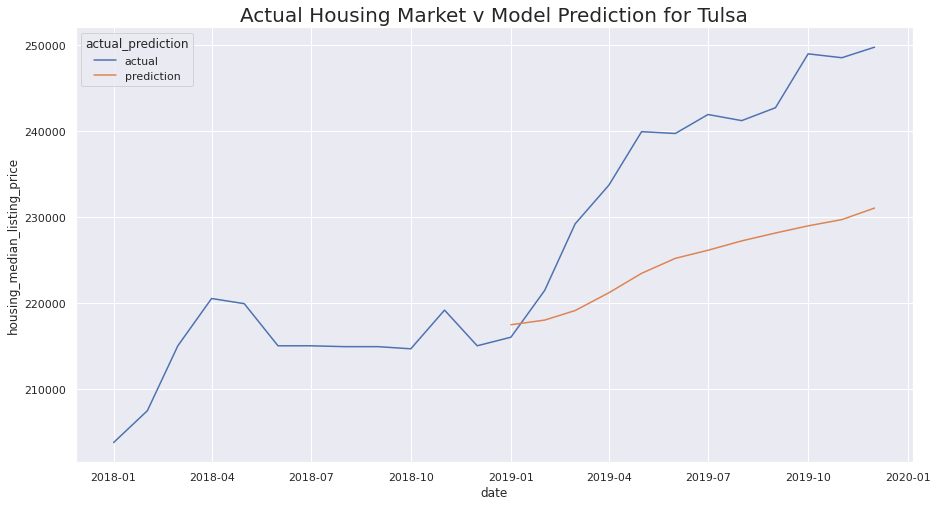

In [17]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.lineplot(data=df_line, x='date',y='housing_median_listing_price', hue='actual_prediction').set_title(f"Actual Housing Market v Model Prediction for {city}", fontsize = 20)

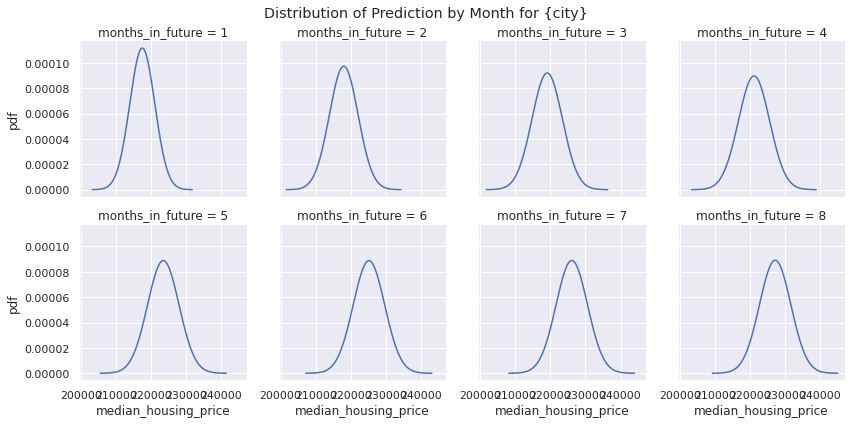

In [18]:
def plot_uncertainty(mean_df, std_df, steps):

    xs = []
    ys = []
    dists = []
    for dist in range(steps):
        mean = mean_df.housing_median_listing_price.loc[dist]
        std = std_df.housing_median_listing_price_4.loc[dist]
        new_xs = np.arange(-4 * std + mean, 4 * std + mean, 100)
        xs.extend(new_xs)
        ys.extend(norm.pdf(new_xs, mean, std))
        dists.extend([dist + 1 for i in range(len(new_xs))])
    plot_df = pd.DataFrame(
        {"median_housing_price": xs, "pdf": ys, "months_in_future": dists}
    )

    sns.set(rc={"figure.figsize": (15, 8)})
    g = sns.FacetGrid(plot_df, col="months_in_future", col_wrap=4)
    g.map(sns.lineplot, "median_housing_price", "pdf")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Distribution of Prediction by Month for {city}")

plot_uncertainty(mean_df, std_df, steps=8)

# Long prediction

In [19]:
df_line

,city_,year,month,date,year_month,housing_median_listing_price,actual_prediction,day
0,Tulsa,2018,1,2018-01-01,2018.01,203750.0000,actual,NaN
1,Tulsa,2018,2,2018-02-01,2018.02,207450.0000,actual,NaN
2,Tulsa,2018,3,2018-03-01,2018.03,215000.0000,actual,NaN
3,Tulsa,2018,4,2018-04-01,2018.04,220499.5000,actual,NaN
4,Tulsa,2018,5,2018-05-01,2018.05,219900.0000,actual,NaN
5,Tulsa,2018,6,2018-06-01,2018.06,215000.0000,actual,NaN
6,Tulsa,2018,7,2018-07-01,2018.07,215000.0000,actual,NaN
7,Tulsa,2018,8,2018-08-01,2018.08,214900.0000,actual,NaN
8,Tulsa,2018,9,2018-09-01,2018.09,214900.0000,actual,NaN
9,Tulsa,2018,10,2018-10-01,2018.10,214649.5000,actual,NaN
